In [ ]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 8 # Amount of documents
V = 12 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 10 


k = 5 # Amount of topics
gamma = 0.2  #

In [ ]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM
D = 50 # Amount of documents
V = 18 # Size of the vocabulary

# (Approximate) Maximum allowed amount of same word repetition in a document (it may be lower in practise due to the data generation strategy)
# To get the actual maximum amount, call Simulator.get_M
M = 5 

k = 6 # Amount of topics
gamma = 0.2

# FA: Since we're testing so much, lets agree on using just 1 small set of global variables for now

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

From now on let's use the following simulated data for further testing

In [4]:
from simulator import Simulator

In [5]:
test_data = Simulator(D, V, M, k, gamma, seed=1967)  # Man on the moon
test_data.generate_all_data()

random_initial_data = Simulator(D, V, M, k, gamma, seed=1969)  # Woodstock Music Festival
random_initial_data.generate_all_data()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z
Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


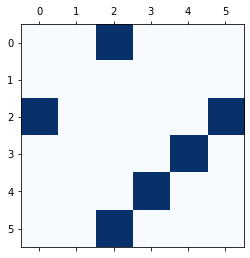

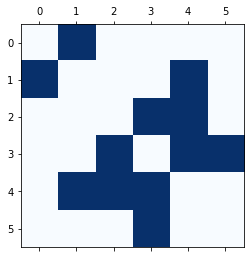

In [6]:
plt.matshow(test_data.G, cmap='Blues')
plt.matshow(random_initial_data.G, cmap='Blues')

# 2. MC SAMPLER

## 2.1.1 Sampling Z (MCMC Sampler)

### Task:

You must implement a function that receives matrices $W$, $\Theta_{i+1}$ and $B_i$ and generates the next $Z_{i+1}$ and $B_{i+1}$.

In [7]:
from samplers import MC_sample_Z
from binder_loss import binder_loss

## 2.1.2 Z Sampling Tests

### MC_sample_Z tests

In [8]:
Z_copy = random_initial_data.Z.copy()

W_copy = test_data.W.copy()
Theta_copy = test_data.Theta.copy()
B_copy = test_data.B.copy()
E_copy = test_data.E.copy()
C_copy = test_data.C.copy()

Z_copy[0]  # Example

array([[-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 2., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.]])

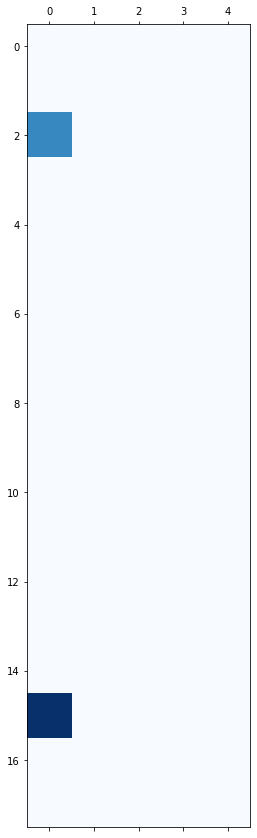

In [9]:
plt.matshow(Z_copy[0], cmap='Blues')

In [10]:
# Check that the function runs with no issues, without side effects but on Z

Z_sample, E_sample, C_sample = MC_sample_Z(Z_copy, W_copy, Theta_copy, B_copy, E_copy, C_copy, debug=True)

assert np.any(Z_copy != random_initial_data.Z)
assert np.all(W_copy == test_data.W)
assert np.all(Theta_copy == test_data.Theta)
assert np.all(B_copy == test_data.B)

Z_sample[0]

array([[-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.]])

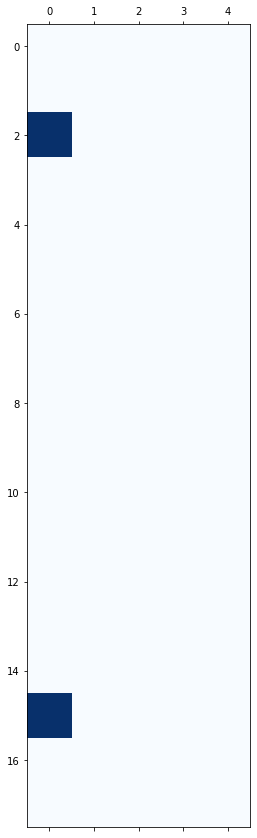

In [11]:
plt.matshow(Z_sample[0], cmap='Blues')

### Binder loss tests

In [12]:
%%time
# Testing
binder_loss(Z_sample, test_data.Z, debug=True)  # Note that all possible pairs are 460320

Error: 4594449
Max error: 20250000
Error %: 22.688637037037036
CPU times: user 76.9 ms, sys: 4.05 ms, total: 81 ms
Wall time: 80.5 ms


0.22688637037037038

In [13]:
%%time
# This MUST return zero
binder_loss(Z_sample, Z_sample, debug=True)

Error: 0
Max error: 20250000
Error %: 0.0
CPU times: user 76.5 ms, sys: 3.84 ms, total: 80.3 ms
Wall time: 79.9 ms


0.0

In [14]:
# Shifting indexes
Z_sample_shifted = Z_sample.copy()
for i in range(k):
    replace_value = (i + 1) % k 
    Z_sample_shifted[Z_sample == i] = replace_value

# This MUST return zero
%time binder_loss(Z_sample, Z_sample_shifted, debug=True)

Error: 0
Max error: 20250000
Error %: 0.0
CPU times: user 63.2 ms, sys: 16 ms, total: 79.2 ms
Wall time: 79.7 ms


0.0

In [15]:
binder_loss(Z_sample[1], test_data.Z[1])

0.1985185185185185

### MC_sample_Z cycle test

In [16]:
%%time

# Check that the Sampler works properly (This will take a while)

errors = []
E_errors = []
C_errors = []
matrix_changes = []
burn_in = 1000
print(f'The sampled Z has {Z_sample.size} words, while the target Z has {test_data.Z.size} words (diff {abs(Z_sample.size-test_data.Z.size)})')
for i in range(5000):
    Z_sample_old = Z_sample.copy()
    E_sample_old = E_sample.copy()
    C_sample_old = C_sample.copy()
    Z_sample, E_sample, C_sample = MC_sample_Z(Z_sample, W_copy, Theta_copy, B_copy, E_sample, C_sample)
    matrix_changes.append(~np.all(Z_sample_old == Z_sample))
    if i >= burn_in:
        errors.append(binder_loss(Z_sample, test_data.Z))  # Computing error wrt the target distribution
        E_errors.append(np.linalg.norm(E_sample - test_data.E))        
        C_errors.append(np.linalg.norm(C_sample - test_data.C))

The sampled Z has 4500 words, while the target Z has 4500 words (diff 0)
CPU times: user 9min 6s, sys: 24 s, total: 9min 30s
Wall time: 9min 50s


Matrix changes (1 = changed, 0 = same)
count    5000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64


<AxesSubplot:>

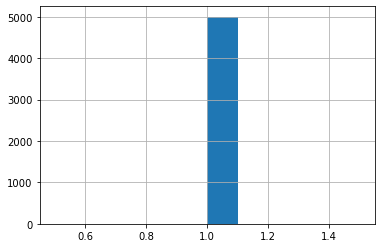

In [17]:
# Matrix should change

matrix_changes = pd.Series(matrix_changes).astype(int)
print("Matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())
matrix_changes.hist()

Error metrics
count    4000.000000
mean        0.226957
std         0.000032
min         0.226842
25%         0.226935
50%         0.226957
75%         0.226979
max         0.227099
dtype: float64


<AxesSubplot:>

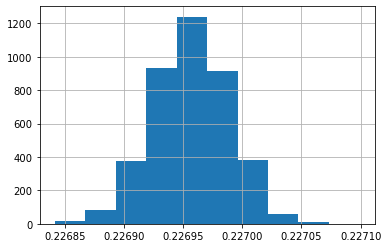

In [18]:
# Error will always be positive and integer, but is it skewed to the left? -> IT IS
errors = pd.Series(errors)
print("Error metrics")
print(errors.describe())
errors.hist()

<AxesSubplot:>

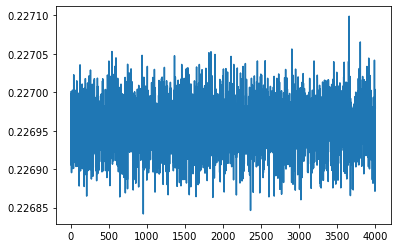

In [19]:
errors.plot()  # See if we still have a caterpillar

E error metrics
count    4000.000000
mean       56.655020
std         1.810401
min        50.179677
25%        55.425626
50%        56.621551
75%        57.844619
max        63.340350
dtype: float64


Text(0.5, 1.0, 'E L2-error distribution')

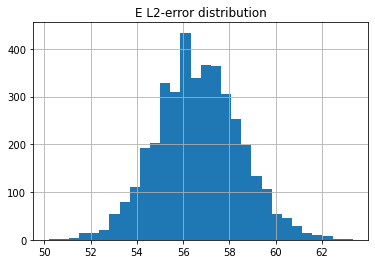

In [20]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target

E_errors = pd.Series(E_errors)
print("E error metrics")
print(E_errors.describe())
E_errors.hist(bins=30)
plt.title('E L2-error distribution')

Text(0.5, 1.0, 'E L2-error series')

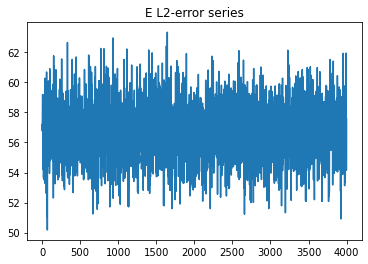

In [21]:
E_errors.plot()
plt.title('E L2-error series')

C error metrics
count    4000.000000
mean       44.463223
std         2.068897
min        37.629775
25%        43.034870
50%        44.429720
75%        45.847574
max        53.047149
dtype: float64


Text(0.5, 1.0, 'C L2-error distribution')

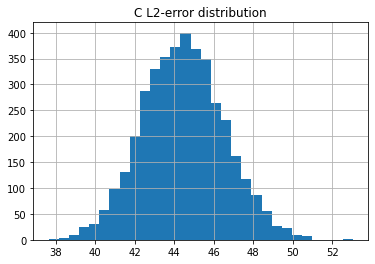

In [22]:
# Error should be distributed close to 0 (I guess...)
# BUG https://trello.com/c/JE1T7Hur/31-mcsamplez-z-is-not-close-to-the-expected-target
C_errors = pd.Series(C_errors)
print("C error metrics")
print(C_errors.describe())
C_errors.hist(bins=30)
plt.title('C L2-error distribution')

Text(0.5, 1.0, 'C L2-error series')

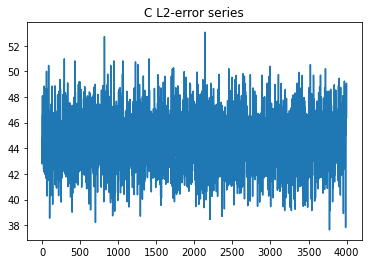

In [23]:
C_errors.plot()
plt.title('C L2-error series')